In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir("/content/gdrive/My Drive/dl_coursework")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
import copy
import utils
import decoder
import trainnet
import wavelet
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

def train_inpainting(net, num_epoches, lr, img_noisy, img_clean, k_channels, img_mask_tensor, net_input=None, lr_decay_step=0):
    if net_input == None:
        net_input = torch.zeros([1, k_channels, 16, 16])
        net_input = net_input.uniform_()
        net_input *= 1./10

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    if lr_decay_step != 0:
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)
    else:
        scheduler = None

    loss_noisy = []
    loss_clean = []

    best_net = copy.deepcopy(net)
    best_net_loss = 1000000

    net = net.cuda()
    net_input = net_input.cuda()
    img_noisy = img_noisy.cuda()
    img_clean = img_clean.cuda()
    img_mask_tensor = img_mask_tensor.cuda()
    net.train()

    for epoch in range(num_epoches):
        optimizer.zero_grad()
        output = net(net_input)
        loss = loss_function(output*img_mask_tensor, img_noisy*img_mask_tensor)
        # print(loss)
        loss.backward()
        optimizer.step()
        if scheduler != None:
            scheduler.step()

        loss_noisy.append(loss.item())
        loss2 = loss_function(output, img_clean)
        loss_clean.append(loss2.item())
        
        if loss < best_net_loss:
            best_net = copy.deepcopy(net)
            best_net_loss = loss

        if epoch % 1000 == 0:
            print(loss)            
    
    best_net.eval()

    return best_net, loss_noisy, loss_clean, net_input

In [0]:
img_path = './test_data/poster_rgb.png'
img_pil = Image.open(img_path)
img_clean_np = utils.pil_numpy(img_pil)
img_clean_tensor = utils.np_tensor(img_clean_np)

output_channels = img_clean_np.shape[0]
img_mask_pil = Image.open('./test_data/mask.png')
img_mask_np = utils.pil_numpy(img_mask_pil)
img_mask_np = np.array([img_mask_np[0,:,:] / np.max(img_mask_np) ] * output_channels)
img_mask_tensor = utils.np_tensor(img_mask_np)

In [0]:
img_mask_np.shape

(3, 512, 512)

In [6]:
img_mask_np

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]], dtype=float32)

In [0]:
img_noisy_tensor = img_clean_tensor * img_mask_tensor
img_noisy_np = utils.tensor_numpy(img_noisy_tensor)

# k=320

In [0]:
net_320 = decoder.Decoder(k_channels=320, output_channels=output_channels, upsample_times = 5)

print("The number of net parameters is: ", utils.parameters_number(net_320))

net_320, mse_n_320, mse_t_320, ni_320 = train_inpainting(net=net_320,
                                                         num_epoches=20000,
                                                         lr=0.01,
                                                         img_noisy=img_noisy_tensor,
                                                         img_clean=img_clean_tensor,
                                                         img_mask_tensor=img_mask_tensor,
                                                         k_channels=320
                                                         )

The number of net parameters is:  619200
tensor(0.0959, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(7.0596e-05, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(8.6967e-05, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.6982e-05, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(4.1375e-05, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(5.8283e-05, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(4.5173e-05, device='cuda:0', grad_fn=<MseLossBa

In [0]:
out_img_np_320 = net_320(ni_320).cpu().detach().numpy()[0]

(-0.5, 511.5, 511.5, -0.5)

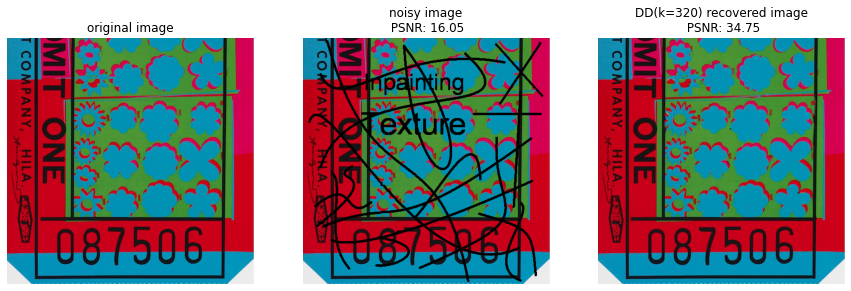

In [0]:
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(1,3)
    
ax[0].imshow(np.clip(img_clean_np.transpose(1, 2, 0),0,1)) 
ax[0].set_title('original image')
ax[0].axis('off')
    
ax[1].imshow(np.clip(img_noisy_np.transpose(1, 2, 0),0,1))
ax[1].set_title("noisy image\n PSNR: %.2f" % utils.psnr(img_clean_np,img_noisy_np))
ax[1].axis('off')

ax[2].imshow(np.clip(out_img_np_320.transpose(1, 2, 0),0,1))
ax[2].set_title("DD(k=320) recovered image\n PSNR: %.2f" % utils.psnr(img_clean_np,out_img_np_320)) 
ax[2].axis('off')  

# k=128

In [0]:
net_128 = decoder.Decoder(k_channels=128, output_channels=output_channels, upsample_times = 5)

print("The number of net parameters is: ", utils.parameters_number(net_128))

net_128, mse_n_128, mse_t_128, ni_128 = train_inpainting(net=net_128,
                                                         num_epoches=20000,
                                                         lr=0.01,
                                                         img_noisy=img_noisy_tensor,
                                                         img_clean=img_clean_tensor,
                                                         img_mask_tensor=img_mask_tensor,
                                                         k_channels=128
                                                         )

The number of net parameters is:  100224
tensor(0.0932, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0007, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0004, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0006, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0002, 

In [0]:
out_img_np_128 = net_128(ni_128).cpu().detach().numpy()[0]

(-0.5, 511.5, 511.5, -0.5)

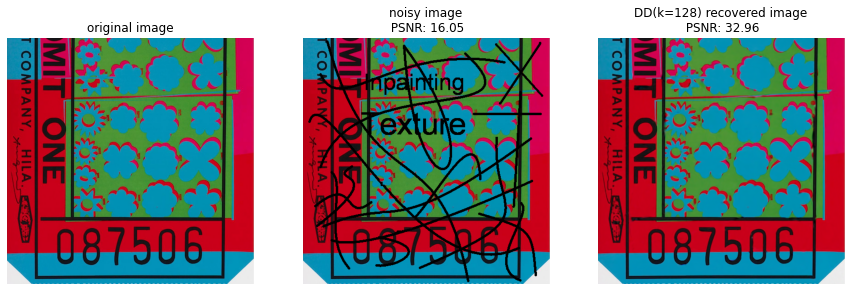

In [0]:
fig = plt.figure(figsize=(15,15))
ax = fig.subplots(1,3)
    
ax[0].imshow(np.clip(img_clean_np.transpose(1, 2, 0),0,1)) 
ax[0].set_title('original image')
ax[0].axis('off')
    
ax[1].imshow(np.clip(img_noisy_np.transpose(1, 2, 0),0,1))
ax[1].set_title("noisy image\n PSNR: %.2f" % utils.psnr(img_clean_np,img_noisy_np))
ax[1].axis('off')

ax[2].imshow(np.clip(out_img_np_128.transpose(1, 2, 0),0,1))
ax[2].set_title("DD(k=128) recovered image\n PSNR: %.2f" % utils.psnr(img_clean_np,out_img_np_128)) 
ax[2].axis('off') 